Found 1883 images belonging to 7 classes.
Found 70 images belonging to 7 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


59/59 ━━━━━━━━━━━━━━━━━━━━ 397s 6s/step - accuracy: 0.1834 - loss: 78.1600 - val_accuracy: 0.2571 - val_loss: 2.2354
Epoch 2/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 91s 712ms/step - accuracy: 0.2358 - loss: 1.9703 - val_accuracy: 0.1857 - val_loss: 1.8762
Epoch 3/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 44s 702ms/step - accuracy: 0.2188 - loss: 1.8805 - val_accuracy: 0.2143 - val_loss: 1.8406
Epoch 4/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 44s 723ms/step - accuracy: 0.2112 - loss: 1.8927 - val_accuracy: 0.1429 - val_loss: 1.9461
Epoch 5/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 45s 729ms/step - accuracy: 0.1581 - loss: 1.9446 - val_accuracy: 0.1429 - val_loss: 1.9462
Epoch 6/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 43s 694ms/step - accuracy: 0.1503 - loss: 1.9451 - val_accuracy: 0.1429 - val_loss: 1.9462
Epoch 7/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 82s 692ms/step - accuracy: 0.1459 - loss: 1.9448 - val_accuracy: 0.1429 - val_loss: 1.9463
Epoch 8/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 46s 740ms/step - accuracy: 0.1460 - loss: 1.9454 - val_accuracy: 0.1429

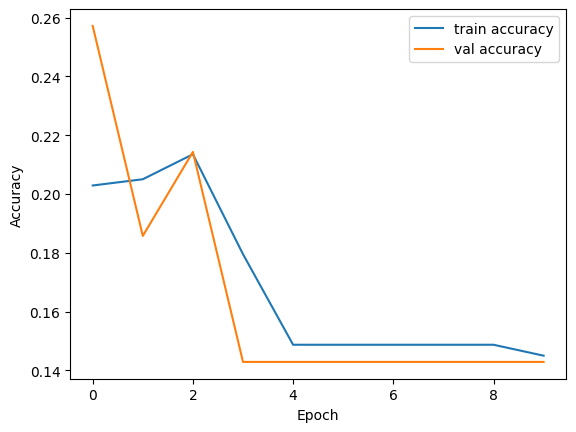

In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
import matplotlib.pyplot as plt

# load data
def load_and_preprocess_data(data_dir, target_size=(256, 256), batch_size=32):
    datagen = ImageDataGenerator(rescale=1./255)
    data = datagen.flow_from_directory(
        data_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical'
    )
    return data

# create model
def create_model(input_shape, num_classes):
    model = Sequential([
        Flatten(input_shape=input_shape),
        Dense(128, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


def main():
    train_data_dir = "/content/drive/MyDrive/DeepLearningTask/Train"
    test_data_dir = "/content/drive/MyDrive/DeepLearningTask/Test"

    # load data
    train_data = load_and_preprocess_data(train_data_dir)
    test_data = load_and_preprocess_data(test_data_dir)

    # create model
    input_shape = train_data.image_shape
    num_classes = len(train_data.class_indices)
    model = create_model(input_shape, num_classes)

    # trainig
    history = model.fit(
        train_data,
        epochs=10,
        validation_data=test_data
    )

    # evaluate
    loss, accuracy = model.evaluate(test_data)
    print(f"Test Accuracy: {accuracy:.2f}")

    # Visualization
    plt.plot(history.history['accuracy'], label='train accuracy')
    plt.plot(history.history['val_accuracy'], label='val accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

if __name__ == "__main__":
    main()

In [2]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
train_data_dir = "/content/drive/MyDrive/DeepLearningTask/Train"
test_data_dir = "/content/drive/MyDrive/DeepLearningTask/Test"

In [4]:
# Parameters
target_size = (224, 224)
batch_size = 32
num_classes = 7
epochs = 20

In [5]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [6]:
test_datagen = ImageDataGenerator(rescale=1./255)

# Load data
train_data = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_data = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 1882 images belonging to 7 classes.
Found 70 images belonging to 7 classes.


In [7]:
# Create model
def create_transfer_learning_model(input_shape, num_classes):
    base_model = MobileNet(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False

    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [9]:
# create model
input_shape = (224, 224, 3)
model = create_transfer_learning_model(input_shape, num_classes)

17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [10]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenet_1.00_224 (Functional)      │ (None, 7, 7, 1024)          │       3,228,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1024)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 7)                   │             903 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,360,967 (12.82 MB)

 Trainable params: 132,103 (516.03 KB)

 Non-trainable params: 3,228,864 (12.32 MB)

In [11]:
class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(train_data.classes),
    y=train_data.classes
)
class_weights = dict(enumerate(class_weights))

In [12]:
# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [13]:
# training model
history = model.fit(
    train_data,
    epochs=epochs,
    validation_data=test_data,
    class_weight=class_weights,
    callbacks=[reduce_lr, early_stopping]
)

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


59/59 ━━━━━━━━━━━━━━━━━━━━ 431s 6s/step - accuracy: 0.4965 - loss: 1.5647 - val_accuracy: 0.9714 - val_loss: 0.1190 - learning_rate: 0.0010
Epoch 2/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 126s 2s/step - accuracy: 0.8991 - loss: 0.3257 - val_accuracy: 0.9857 - val_loss: 0.1099 - learning_rate: 0.0010
Epoch 3/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 126s 2s/step - accuracy: 0.9330 - loss: 0.2324 - val_accuracy: 0.9857 - val_loss: 0.0512 - learning_rate: 0.0010
Epoch 4/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 159s 2s/step - accuracy: 0.9450 - loss: 0.1767 - val_accuracy: 0.9857 - val_loss: 0.0449 - learning_rate: 0.0010
Epoch 5/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 189s 2s/step - accuracy: 0.9501 - loss: 0.1315 - val_accuracy: 0.9714 - val_loss: 0.0675 - learning_rate: 0.0010
Epoch 6/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 139s 2s/step - accuracy: 0.9368 - loss: 0.1679 - val_accuracy: 1.0000 - val_loss: 0.0219 - learning_rate: 0.0010
Epoch 7/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 148s 2s/step - accuracy: 0.9677 - loss: 0.1045 - val_accuracy: 1.00

In [14]:
# Evaluate model
loss, accuracy = model.evaluate(test_data)
print(f"Test Accuracy: {accuracy:.2f}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 1.0000 - loss: 0.0162
Test Accuracy: 1.00


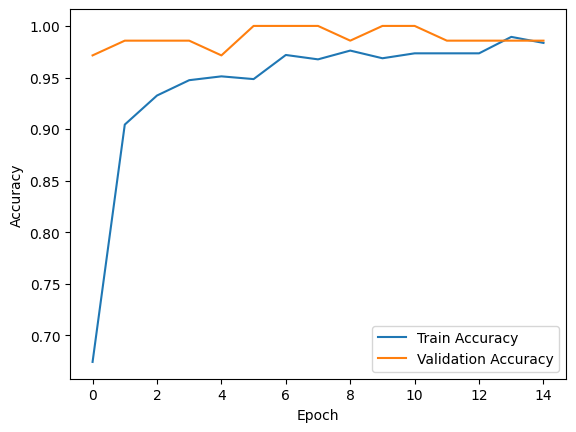

In [15]:
# Visualization
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step


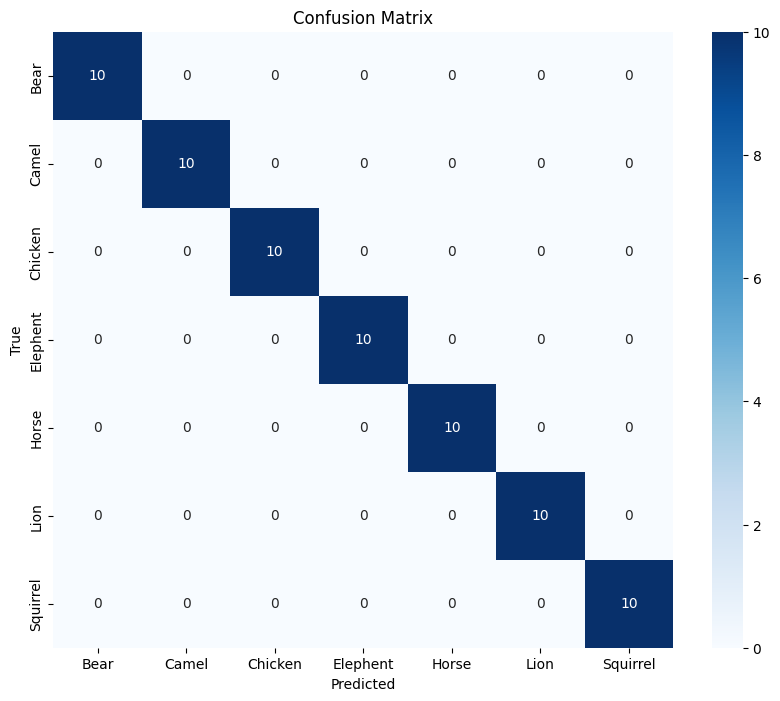

In [19]:
# Confusion Matrix
y_pred = model.predict(test_data)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_data.classes

cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=train_data.class_indices, yticklabels=train_data.class_indices)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [20]:
model.save("Animals_images_classification.h5")

In [24]:
# Import the necessary libraries
from tkinter import Tk, filedialog
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array
from PIL import Image
import numpy as np
import os

# Charger votre modèle
model = load_model("/content/Animals_images_classification.h5")

# Function to get the image path
def get_image_path():
  """
  Opens a file dialog for the user to select an image and returns the path.
  This function is separated from the main logic to make it testable.
  """
  # Create a root Tkinter window (it will be hidden)
  root = Tk()
  root.withdraw()

  # Open the file dialog
  image_path = filedialog.askopenfilename(
      title="Sélectionnez une image",
      filetypes=[("Images", "*.jpg;*.jpeg;*.png")]
  )

  # Destroy the root window
  root.destroy()

  return image_path


# Replace the GUI part with a simple input if running in Google Colab
def predict_image(image_path):
  """
  Predicts the class of an image given its path.
  """
  # Charger et prétraiter l'image
  image = Image.open(image_path)
  image = image.resize((224, 224))  # Adapter à la taille attendue par le modèle
  image_array = img_to_array(image) / 255.0  # Normaliser
  image_array = np.expand_dims(image_array, axis=0)  # Ajouter une dimension pour le batch

  # Faire une prédiction
  prediction = model.predict(image_array)
  predicted_class = np.argmax(prediction)

  # Afficher le résultat
  print(f"Image : {image_path}")
  print("Classe prédite :", predicted_class)

# Check if running in Google Colab and handle image selection accordingly
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

if IN_COLAB:
    from google.colab import files
    uploaded = files.upload()
    for fn in uploaded.keys():
        image_path = fn  # Use the uploaded filename as the image path
        predict_image(image_path)
else:
    # If not in Colab, use the original file dialog approach
    image_path = get_image_path()
    if image_path:
        predict_image(image_path)
    else:
        print("Aucune image sélectionnée.")

Saving OIP-2b1YobOLZcxJwTkwECJAqwHaLf.jpeg to OIP-2b1YobOLZcxJwTkwECJAqwHaLf.jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Image : OIP-2b1YobOLZcxJwTkwECJAqwHaLf.jpeg
Classe prédite : 4
